In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [3]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


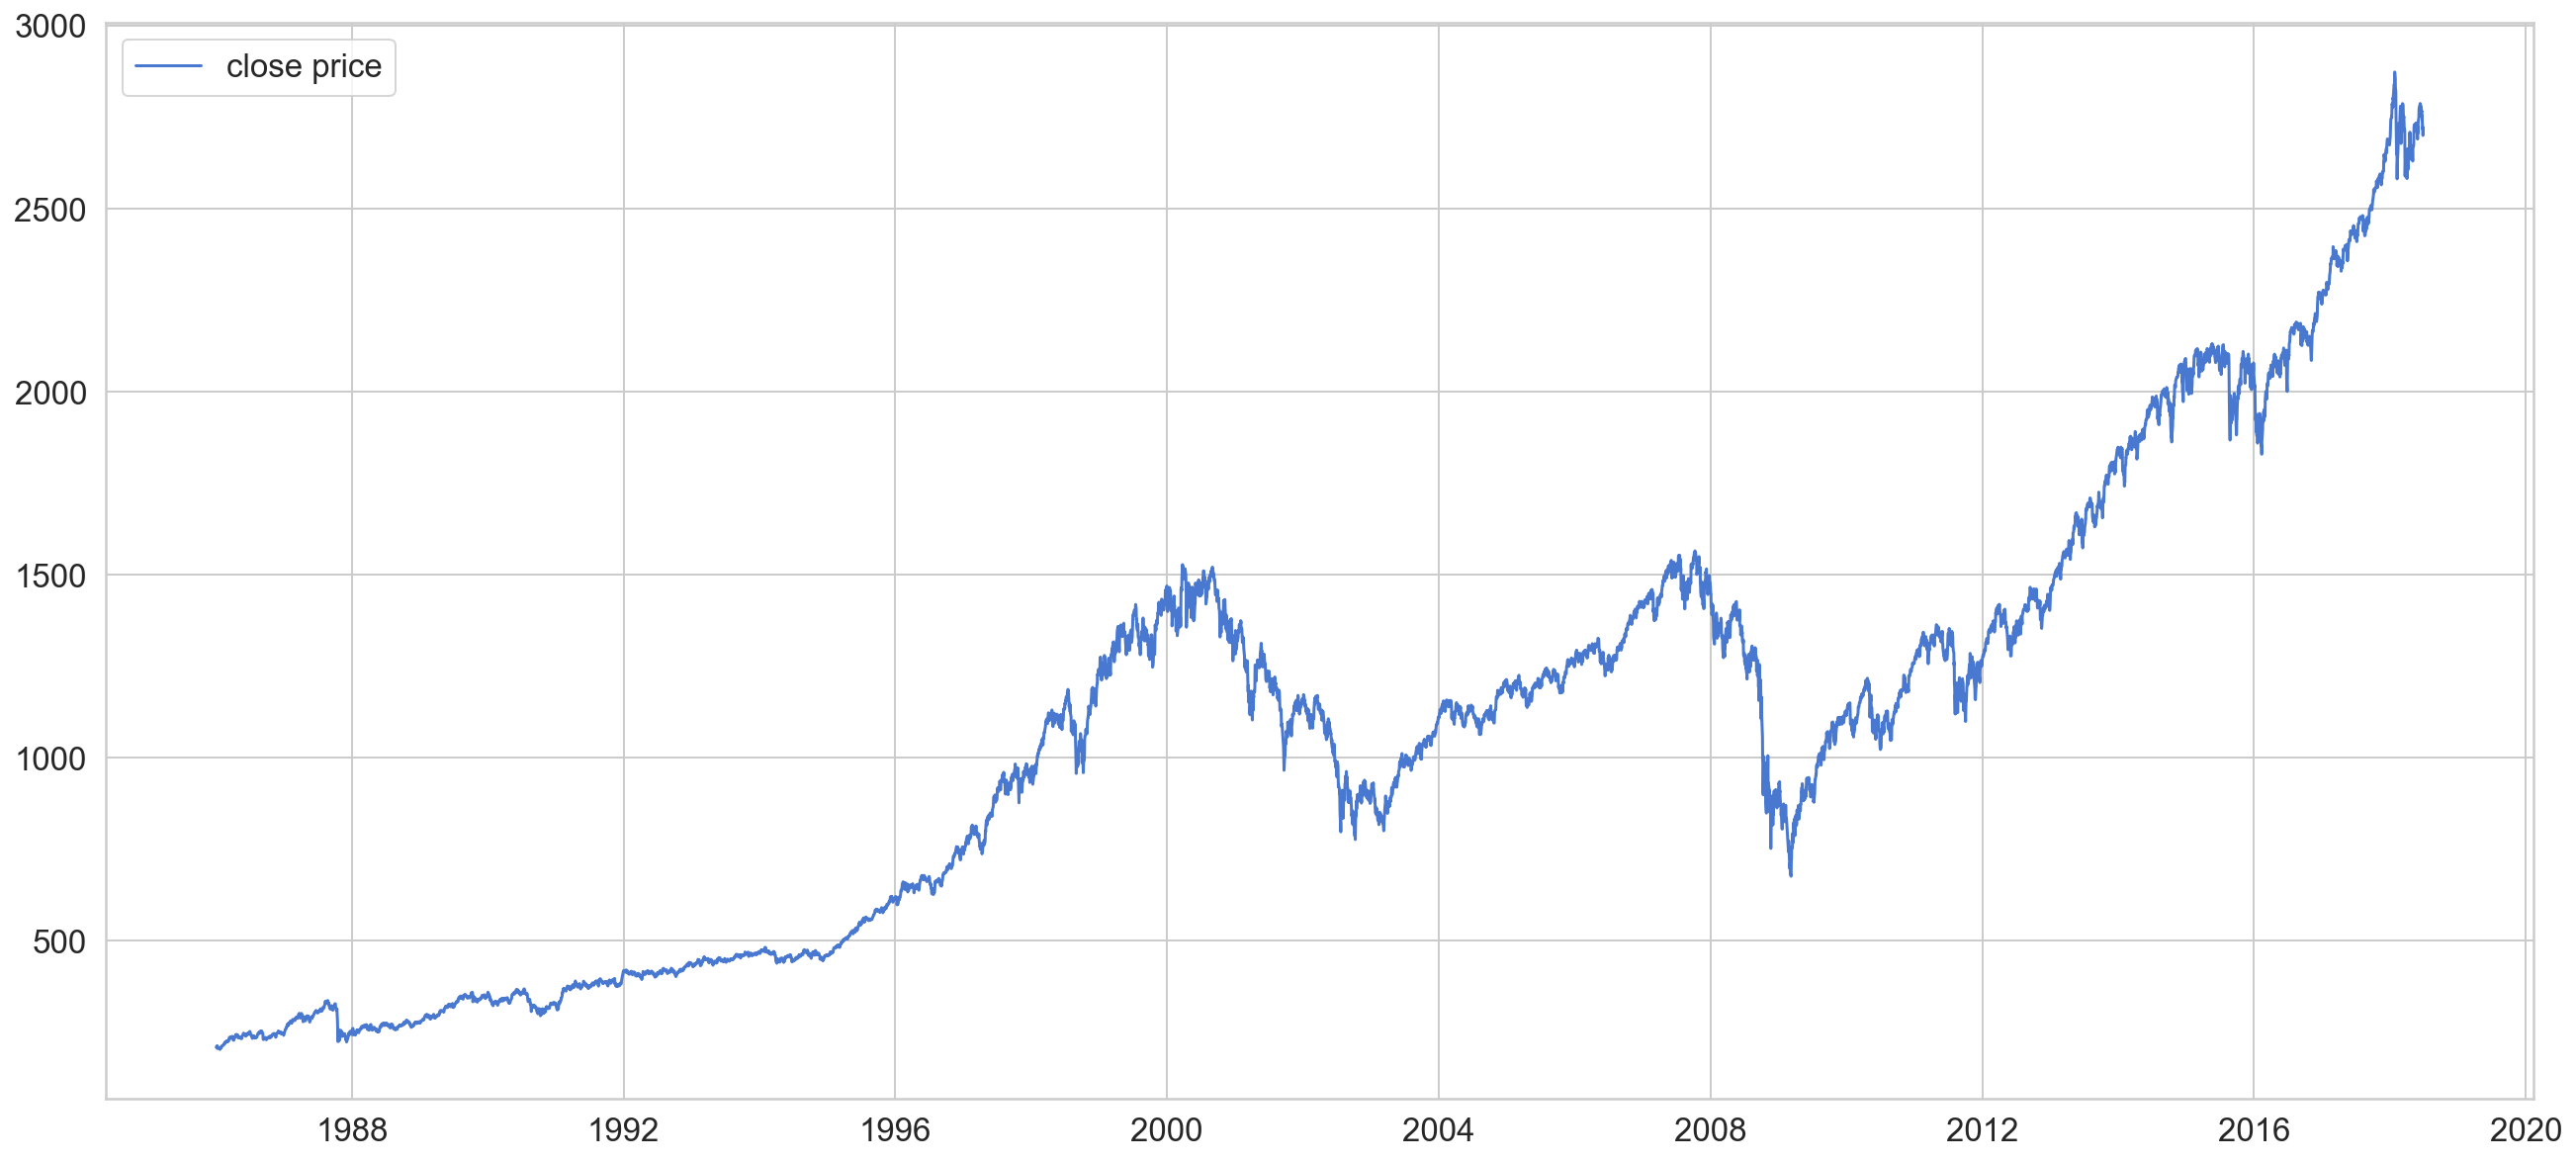

In [4]:
plt.plot(df, label='close price')
plt.legend();

In [5]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [15]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 7s 20ms/step - loss: 0.1712 - val_loss: 0.3528
Epoch 2/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1054 - val_loss: 0.2362
Epoch 3/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1049 - val_loss: 0.2534
Epoch 4/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1325 - val_loss: 0.2524
Epoch 5/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1350 - val_loss: 0.2980
Epoch 6/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1249 - val_loss: 0.2129
Epoch 7/10
218/218 [==============================] - 4s 18ms/step - loss: 0.1218 - val_loss: 0.1431
Epoch 8/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1202 - val_loss: 0.1271
Epoch 9/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1278 - val_loss: 0.1038
Epoch 10/10
218/218 [==============================] - 4s 17ms/step - loss: 0.1333 - val_lo

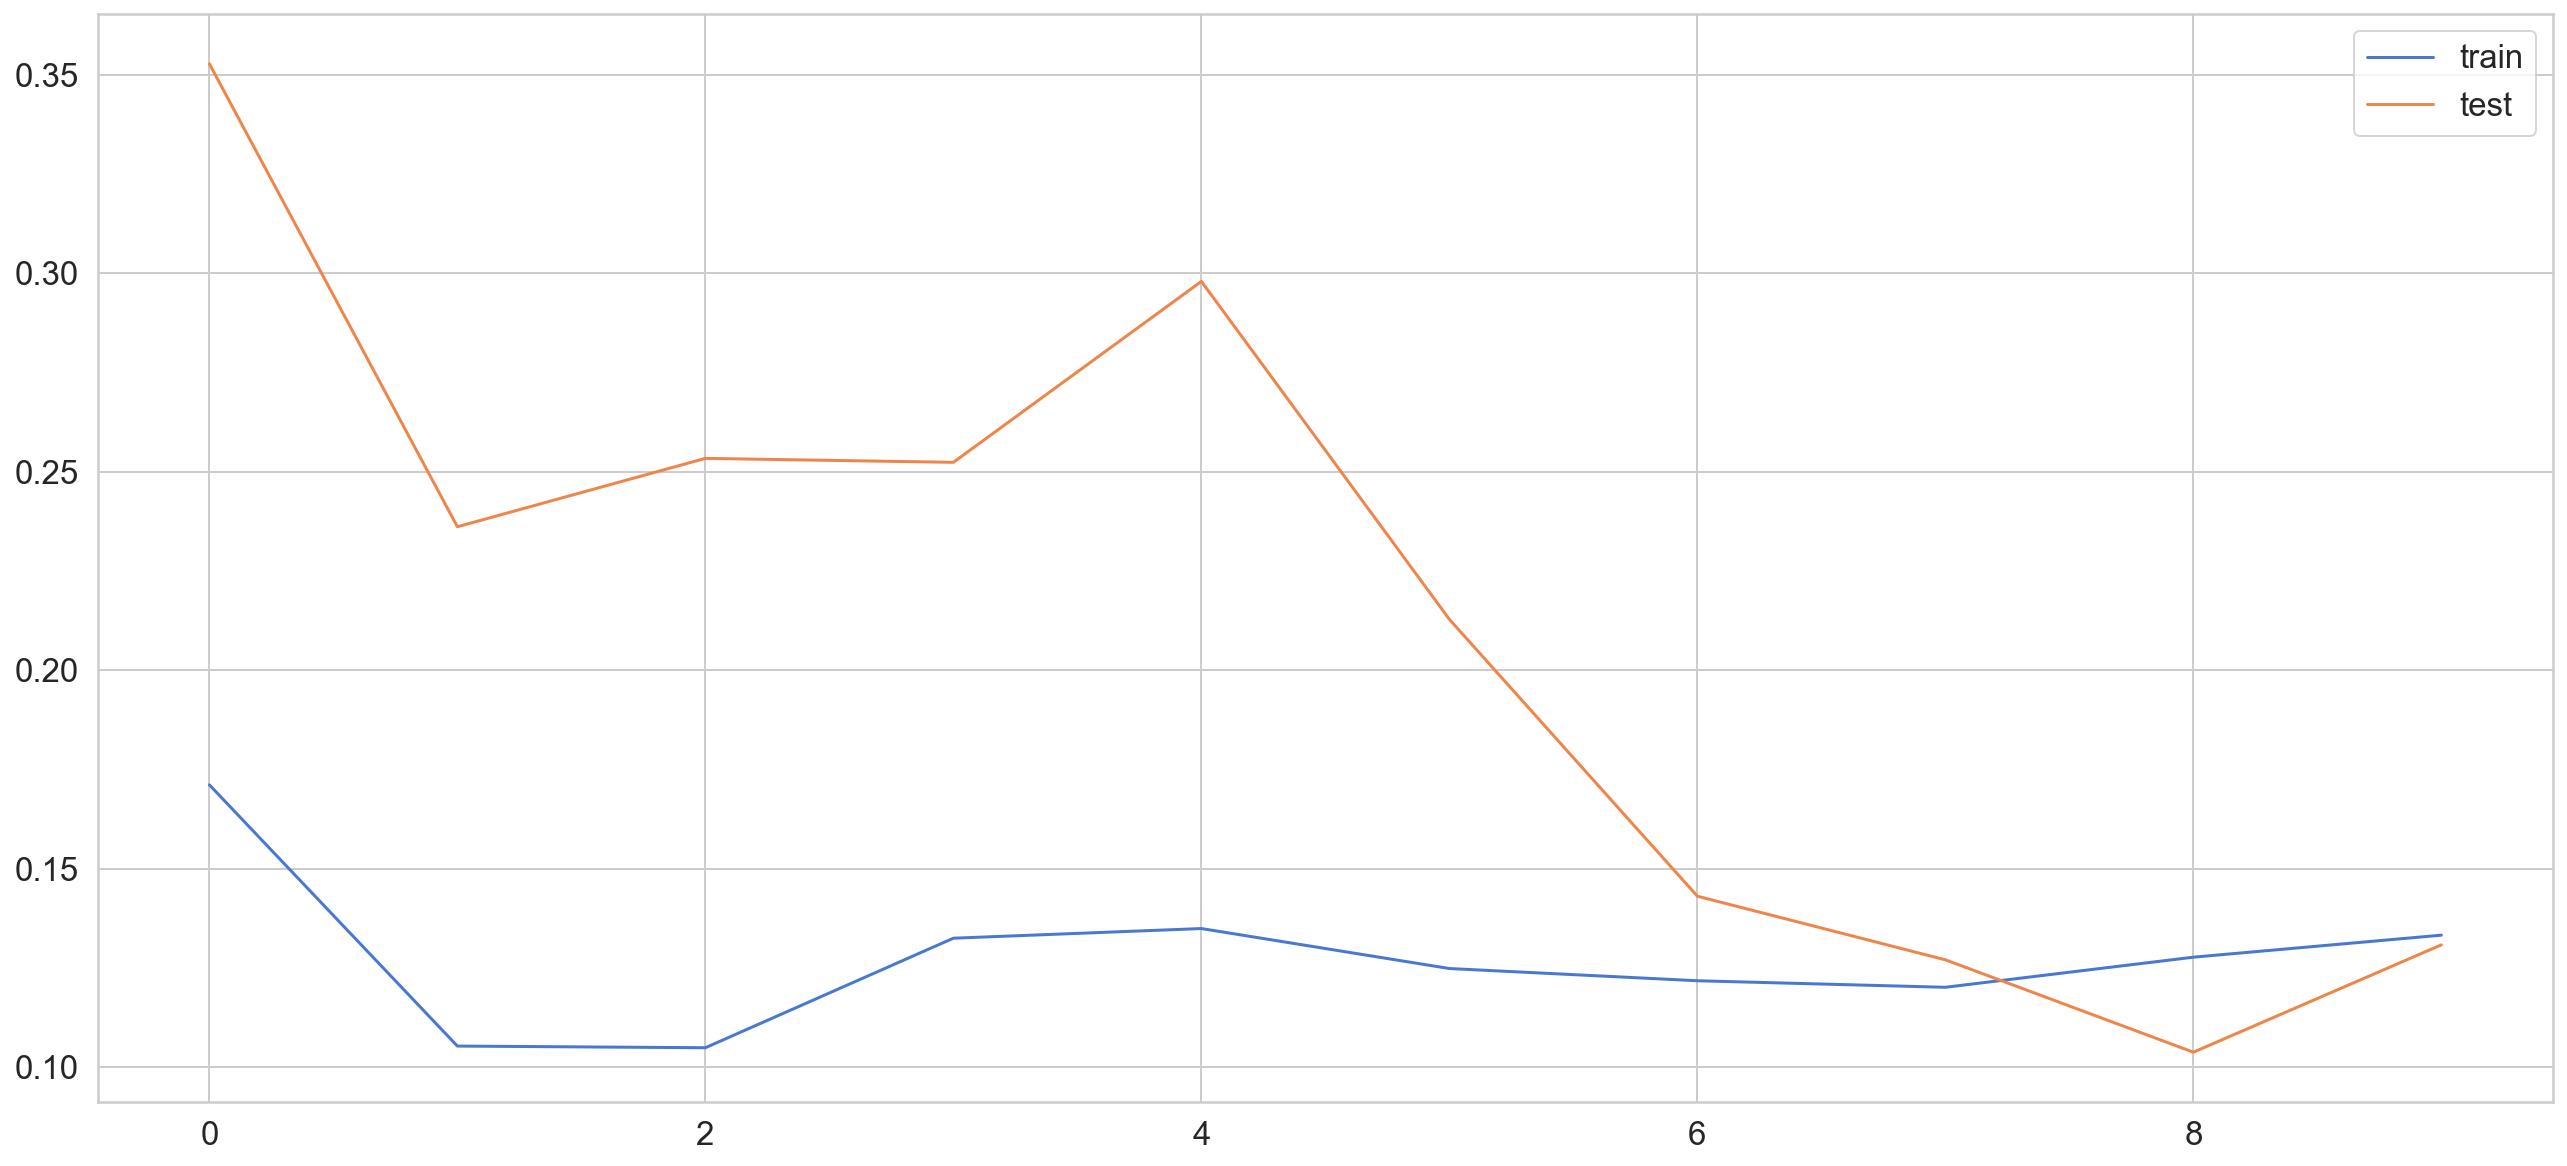

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [18]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

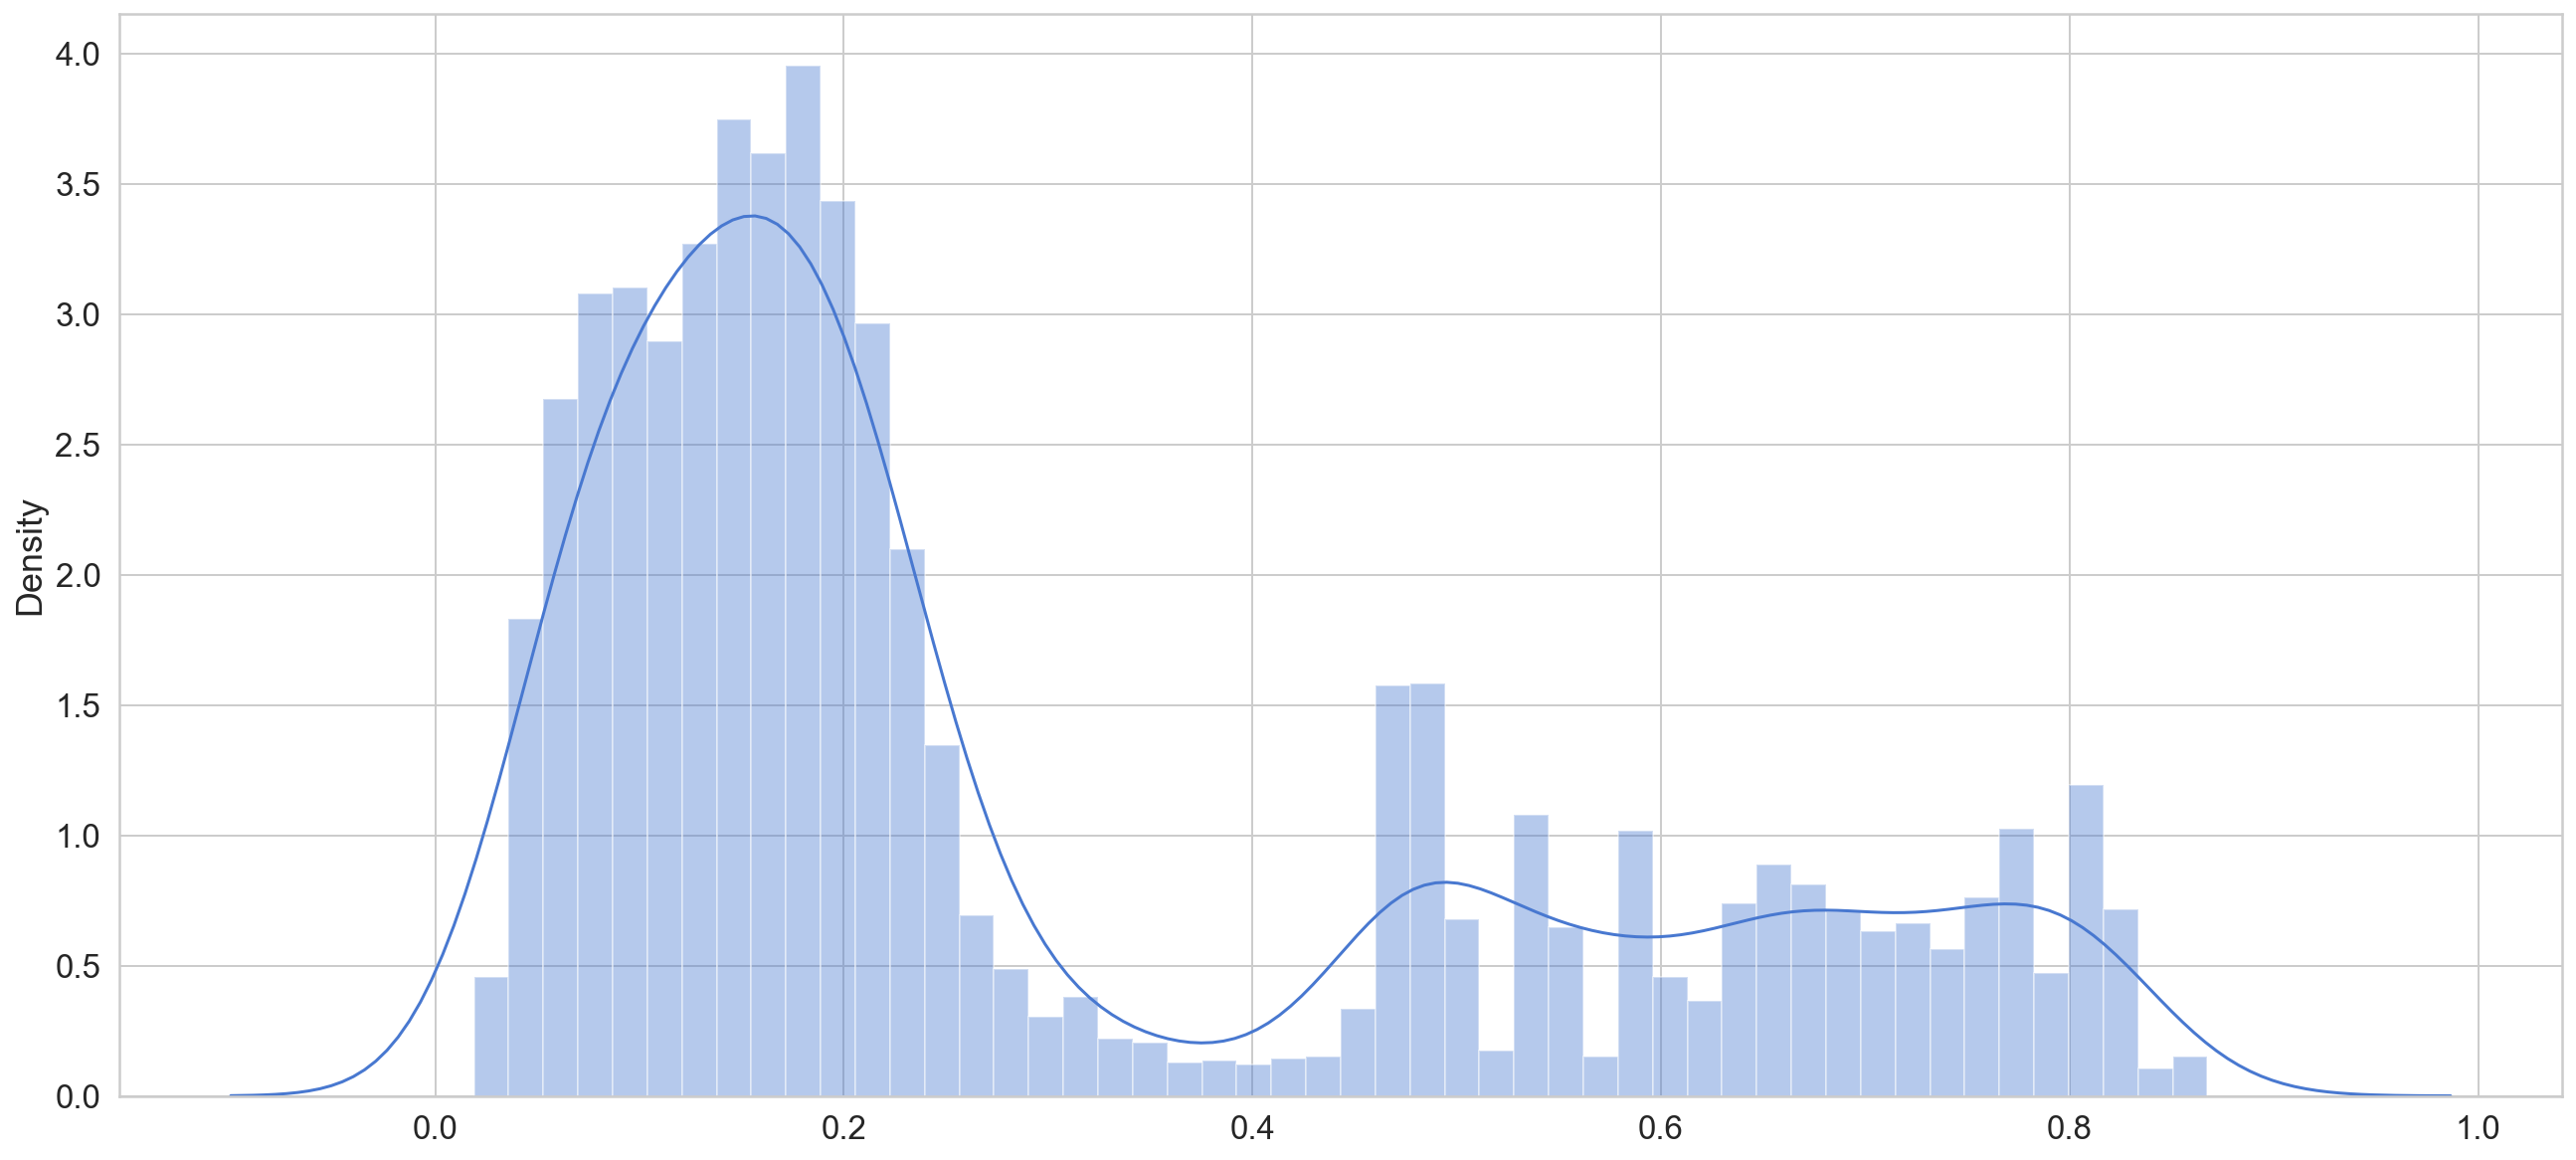

In [19]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [20]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [30]:
THRESHOLD = 0.5

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

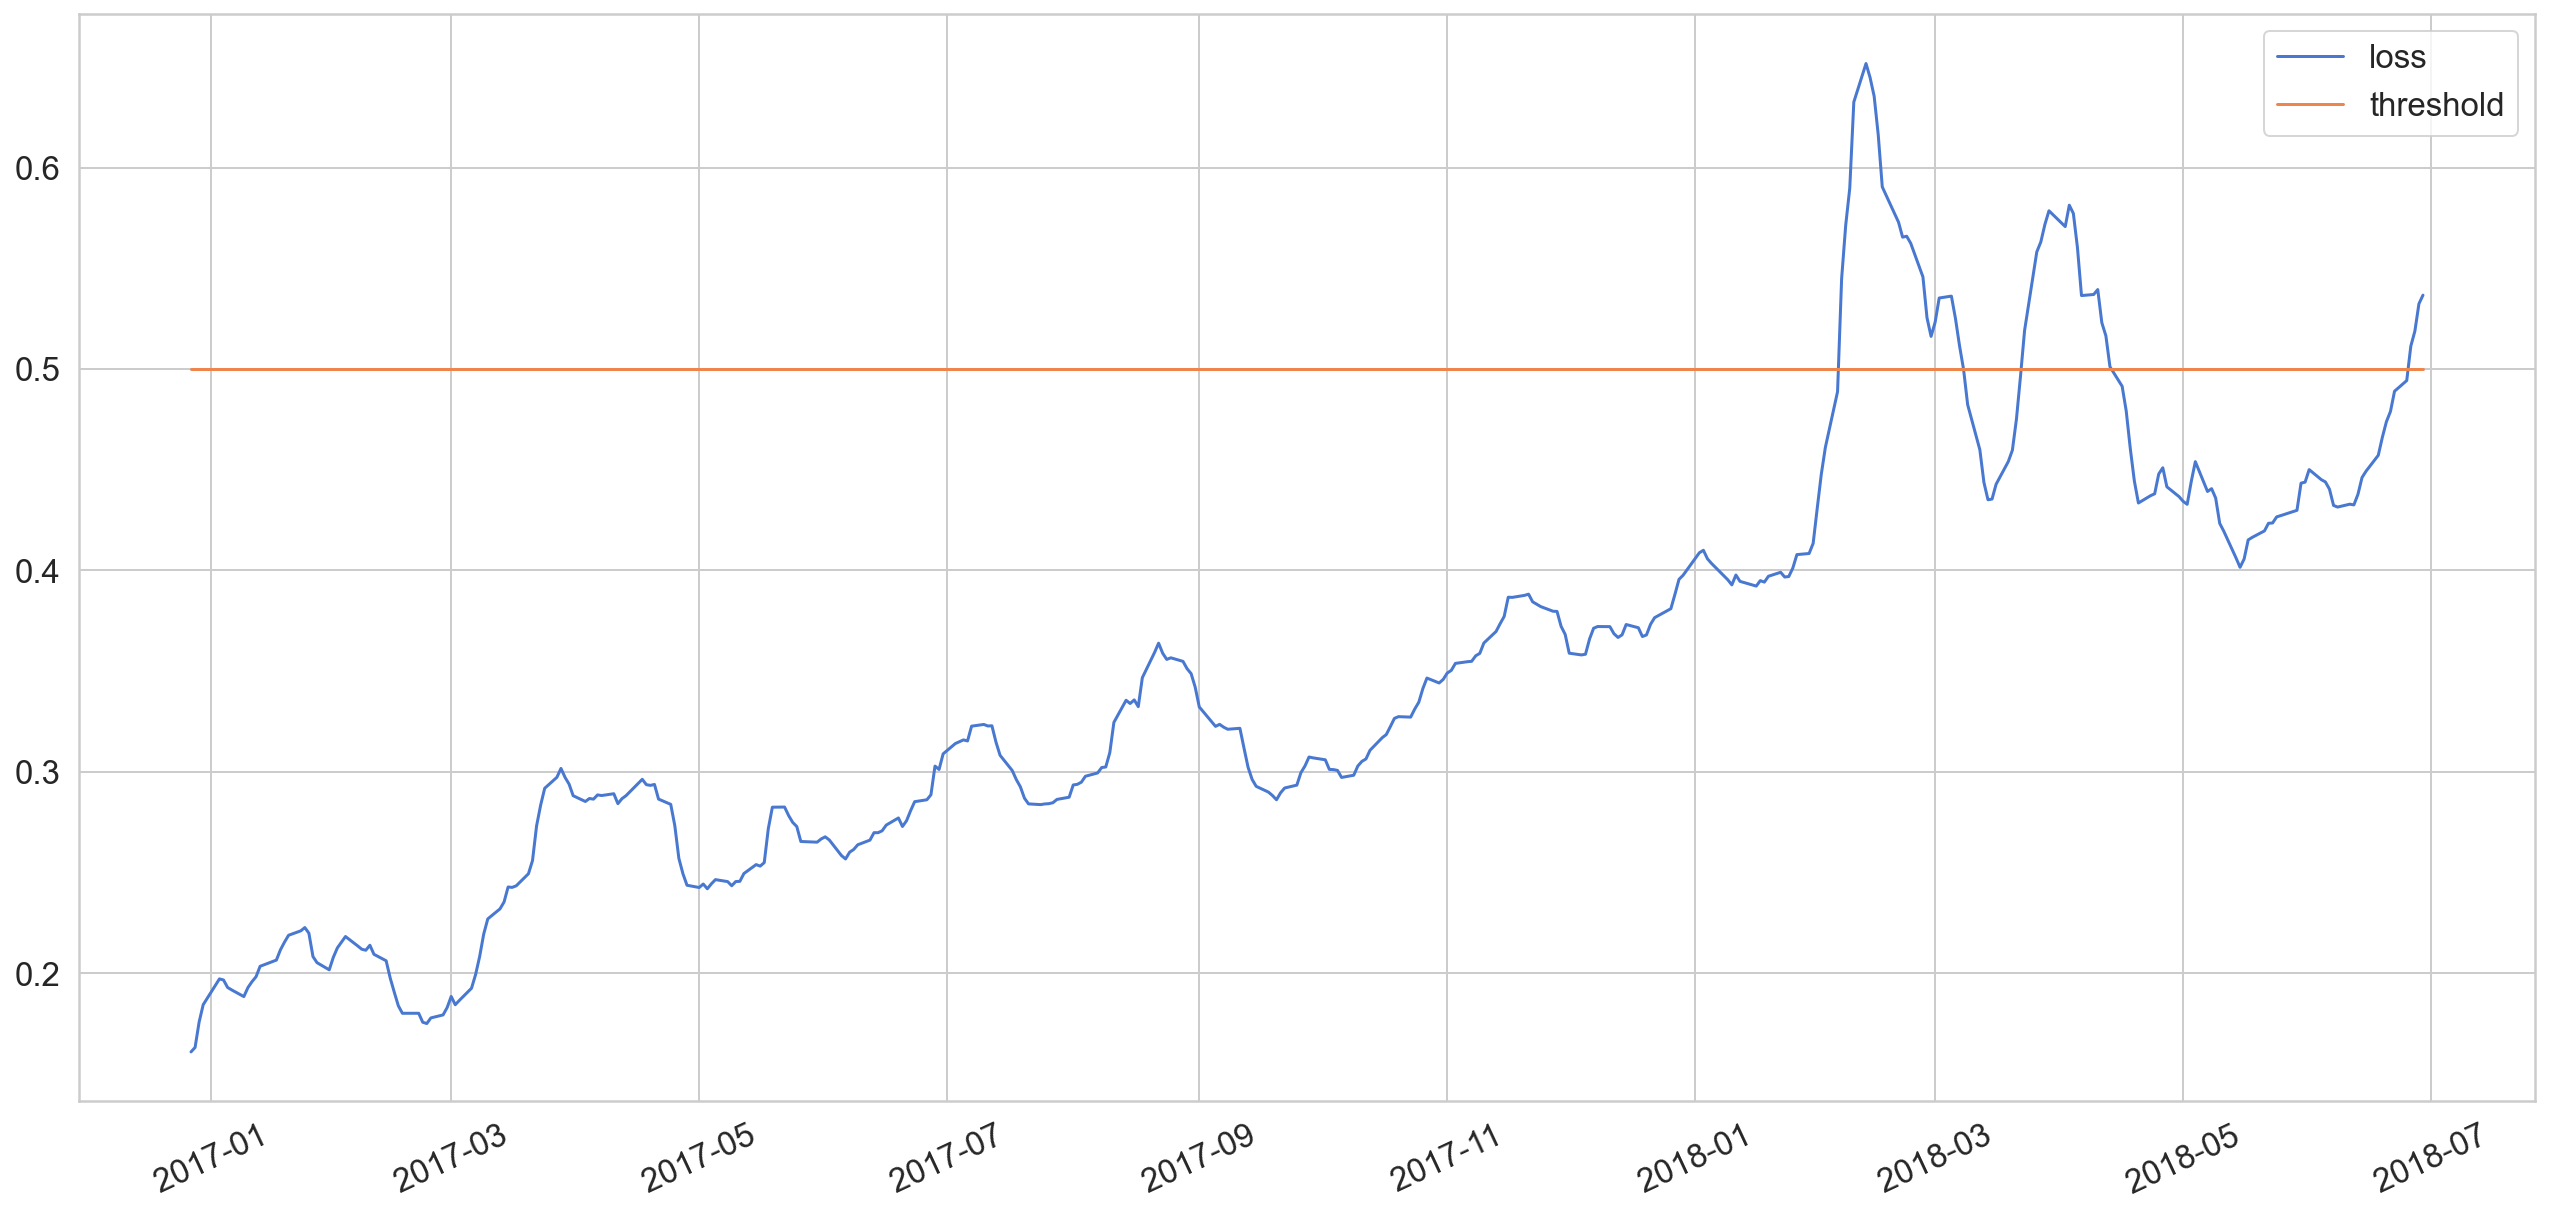

In [31]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [32]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.544800,0.5,True,3.193456
2018-02-07,0.571260,0.5,True,3.168136
2018-02-08,0.589744,0.5,True,2.979068
2018-02-09,0.632508,0.5,True,3.051476
2018-02-12,0.651627,0.5,True,3.119939


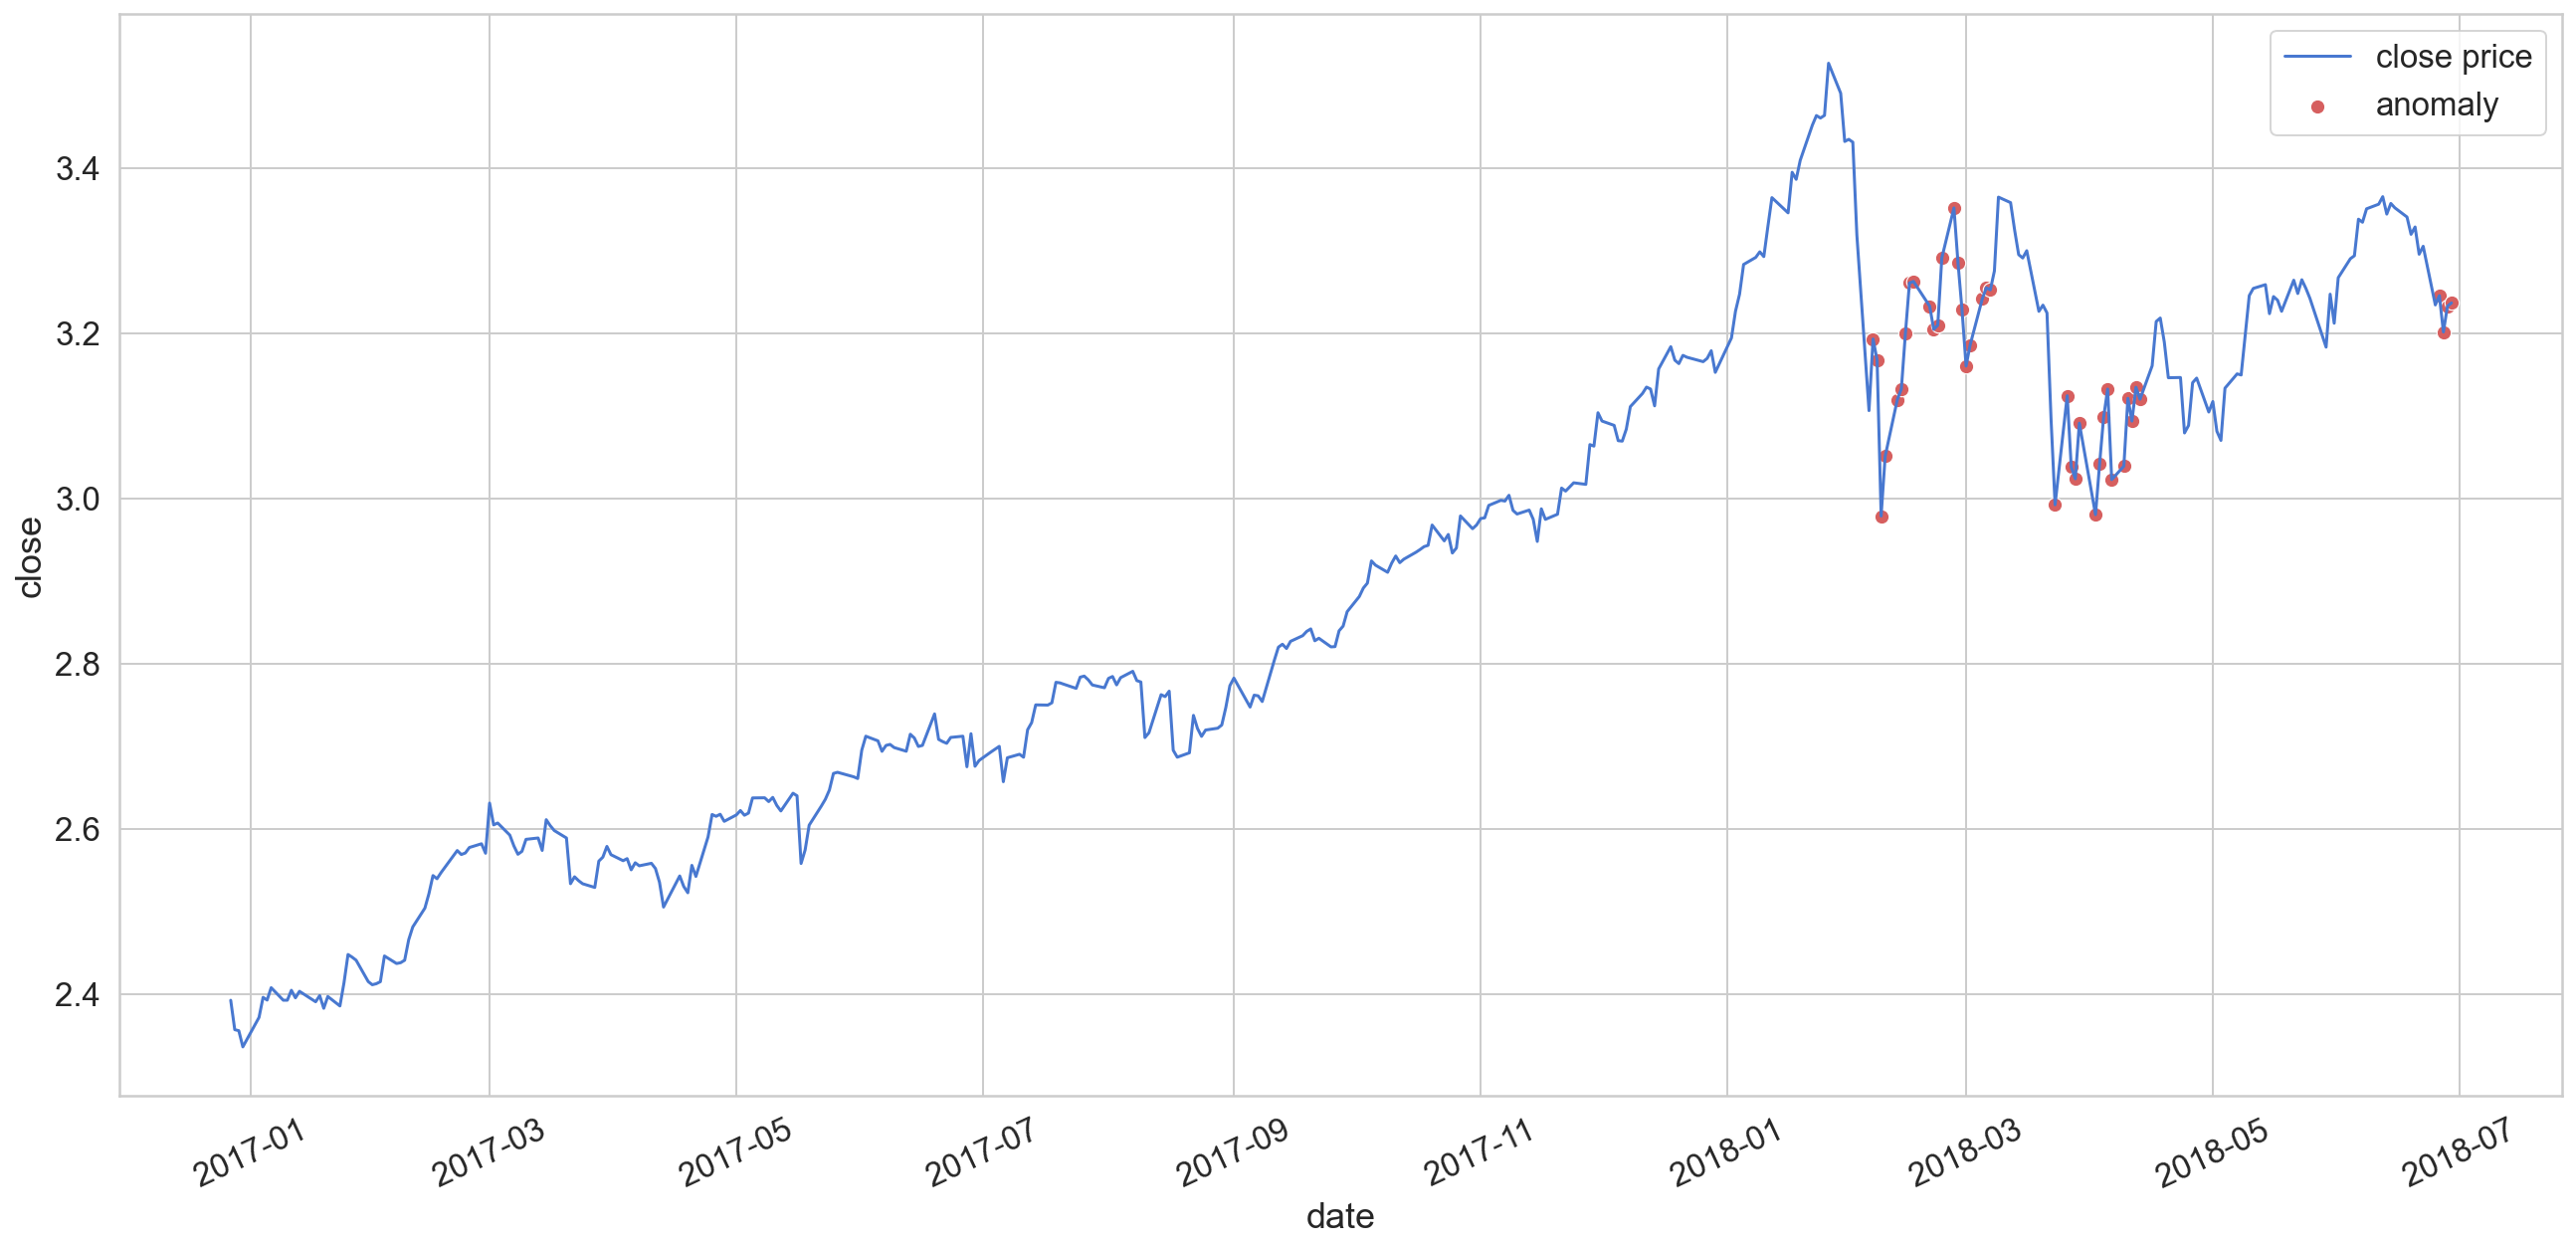

In [41]:
plt.plot(test[TIME_STEPS:].index, test[TIME_STEPS:].close, label='close price');
sns.scatterplot(anomalies.index, anomalies.close, color=sns.color_palette()[3], s=52, label='anomaly')
plt.xticks(rotation=25)
plt.legend();